<a href="https://colab.research.google.com/github/TCB09/202255202117-Teguh/blob/master/Copy_of_Multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://youtu.be/hraKTseOuJA

"""
Dataset from here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html
"""


'\nDataset from here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html\n'

In [3]:
!pip install -q kaggle


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC


In [5]:
import os
os.environ["KAGGLE_USERNAME"] = "teguhchandra"  # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "5c716684032c1135719d64320b5f84c9"  # Ganti dengan API Key Anda

In [6]:
!kaggle datasets download -d teguhchandra/dataset-deeplearning

Dataset URL: https://www.kaggle.com/datasets/teguhchandra/dataset-deeplearning
License(s): CC0-1.0
 98% 476M/486M [00:03<00:00, 184MB/s]
100% 486M/486M [00:03<00:00, 160MB/s]


In [7]:
!unzip dataset-deeplearning.zip -d dataset/

Archive:  dataset-deeplearning.zip
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar1.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar10.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar100.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar101.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar102.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar103.jpg  
  inflating: dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar104.j

In [8]:
# Now let us read metadata to get our Y values (multiple labels)
df = pd.read_csv('dataset/traindataset_TeguhChandraBaskara_202255202117.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)

#df = df.iloc[:2000]  # Loading only first 2000 datapoints for memory reasons
# Need to read images using the tag from metadata.
# Otherwise, if read directly from the folder then images may not correspond to
# the metadata from the csv file.


            id  laptop  pena  buku  penggaris
0  gambar1.jpg       1     1     1          1
1  gambar2.jpg       1     1     1          1
2  gambar3.jpg       0     1     0          1
3  gambar4.jpg       1     0     1          1
4  gambar5.jpg       1     1     0          0
Index(['id', 'laptop', 'pena', 'buku', 'penggaris'], dtype='object')


In [9]:
print(df.columns)


Index(['id', 'laptop', 'pena', 'buku', 'penggaris'], dtype='object')


In [10]:
IMG_SIZE = 224  # atau nilai lain sesuai ukuran input modelmu


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Augmentasi: flip horizontal, zoom, shear, dan rotation ringan
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Buat list untuk menampung gambar augmentasi
augmented_images = []
# Jumlah augmentasi per gambar
AUGMENT_PER_IMAGE = 1  # bisa ditambah

# Loop sebagian kecil data untuk augmentasi (agar tidak overload)
for i in range(min(500, len(df))):  # 500 gambar pertama saja misalnya
    img_path = f"/content/dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/{df['id'][i]}"
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE, 3))
    img = image.img_to_array(img)
    img = img.reshape((1,) + img.shape)  # reshape jadi (1, height, width, channels)

    # Buat augmentasi dan simpan satu contoh per gambar
    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(AUGMENT_PER_IMAGE):
        aug_img = next(aug_iter)[0] / 255.0
        augmented_images.append(aug_img)


In [12]:
SIZE = 200
X_dataset = []

image_directory = '/content/dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117'

for i in tqdm(range(df.shape[0])):
    try:
        img_path = image_directory + '/' + df['id'][i]
        if not os.path.exists(img_path):
            print(f"File tidak ditemukan: {img_path}")
            continue
        img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
        img = image.img_to_array(img)
        img = img / 255.
        X_dataset.append(img)
    except Exception as e:
        print(f"Error saat memproses gambar ke-{i} ({df['id'][i]}): {e}")

X = np.array(X_dataset)


100%|██████████| 300/300 [00:20<00:00, 14.59it/s]


In [13]:
#
print(df['id'][101])


gambar102.jpg


In [14]:
print(df.loc[101, ['laptop', 'pena', 'buku', 'penggaris']])


laptop       1
pena         0
buku         1
penggaris    1
Name: 101, dtype: object


In [15]:
IMG_SIZE = 200  # Sesuai dengan proses resize gambar

# Ambil label (y) dan hapus kolom 'id'
y = np.array(df.drop(['id'], axis=1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

# Tidak perlu threshold jika label sudah biner (0 dan 1)


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # Freeze semua layer awal

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(y.shape[1], activation='sigmoid')(x)  # multi-label output

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


<ipython-input-16-ce34d034c270>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 100, 100,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 100, 100,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 100, 100,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 100, 100,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 100, 100,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 100, 100,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 101, 101,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 50, 50,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 50, 50,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback untuk menghentikan training lebih awal jika val_loss tidak membaik
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback untuk menurunkan learning rate saat val_loss stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


In [19]:
# Normalisasi label (jika belum float32)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [20]:
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3619 - loss: 0.7381 - val_accuracy: 0.2556 - val_loss: 0.5671
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2436 - loss: 0.6407 - val_accuracy: 0.2444 - val_loss: 0.5072
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3053 - loss: 0.5269 - val_accuracy: 0.4222 - val_loss: 0.4400
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3832 - loss: 0.5095 - val_accuracy: 0.5111 - val_loss: 0.4156
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4663 - loss: 0.4582 - val_accuracy: 0.4556 - val_loss: 0.3876
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4143 - loss: 0.4034 - val_accuracy: 0.4111 - val_loss: 0.3718
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3733 - loss: 0.3606 - val_accuracy: 0.4667 - val_loss: 0.3557
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4939 - loss: 0.3840 - val_accuracy: 0.3556 - val_loss: 0.3429
Epoch 9/6

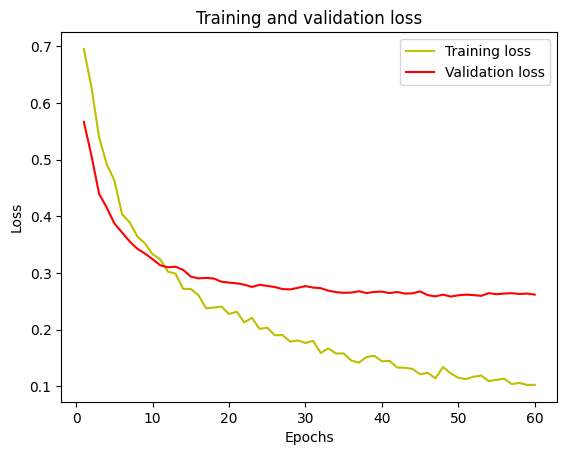

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

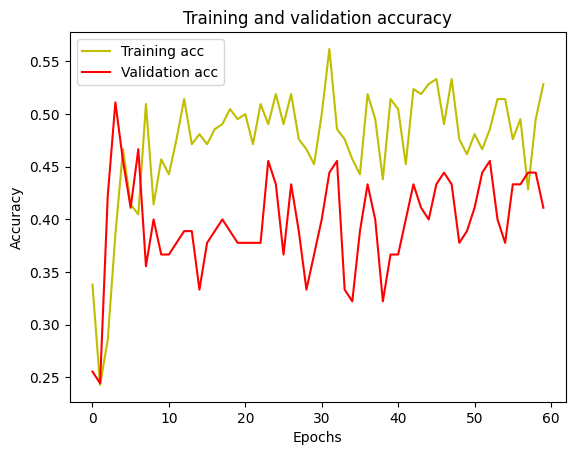

In [22]:
acc = history.history.get('accuracy') or history.history.get('binary_accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_binary_accuracy')
plt.plot(acc, 'y', label='Training acc')
plt.plot(val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


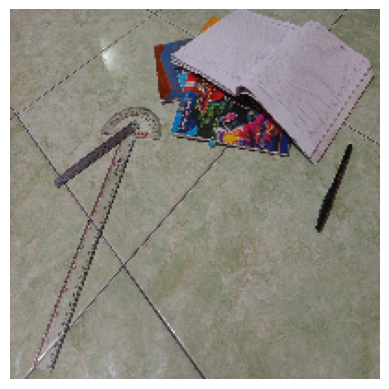

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top label predictions:
buku: 0.998
penggaris: 0.984
pena: 0.929
laptop: 0.025


In [23]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Ubah path gambar ke lokasi yang sesuai dengan struktur dataset kamu
# Misal kamu ingin validasi dengan gambar ke-100:
img_path = '/content/dataset/DatasetMultilabel_TeguhChandraBaskara_202255202117/DatasetMultilabel_TeguhChandraBaskara_202255202117/gambar100.jpg'

# Load dan praproses gambar
img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

# Tampilkan gambar
plt.imshow(img_array)
plt.axis('off')
plt.show()

# Persiapkan input untuk prediksi
img_array = np.expand_dims(img_array, axis=0)

# Ambil nama label dari dataframe
classes = np.array(df.columns[1:])  # karena kolom ke-0 adalah 'id'

# Prediksi
proba = model.predict(img_array)
sorted_categories = np.argsort(proba[0])[:-6:-1]  # Top 5 label dengan probabilitas tertinggi

# Tampilkan hasil prediksi
print("Top label predictions:")
for i in sorted_categories:
    print(f"{classes[i]}: {proba[0][i]:.3f}")


In [24]:
# Jumlah label di dataset kamu hanya 4, jadi loop hanya sampai jumlah itu
for i in range(len(sorted_categories)):
    print(f"{classes[sorted_categories[i]]} ({proba[0][sorted_categories[i]]:.3f})")


buku (0.998)
penggaris (0.984)
pena (0.929)
laptop (0.025)


In [25]:
###################################################

results = model.evaluate(X_test, y_test)
print("Accuracy = ", results[1] * 100, "%")

################################################################

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4282 - loss: 0.2511
Accuracy =  41.111111640930176 %


In [26]:
# prompt: berikan code evaluasi model

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels (e.g., using a threshold)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold

# Calculate and print the classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))


# Calculate and print the confusion matrix (optional)
# Note: Confusion matrices are best visualized for binary or few-class problems
# For multi-label, confusion matrix for each label is more informative
for i in range(len(classes)):
  print(f"Confusion Matrix for {classes[i]}:")
  print(confusion_matrix(y_test[:,i], y_pred_classes[:,i]))


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 966ms/step
              precision    recall  f1-score   support

      laptop       0.91      0.98      0.94        59
        pena       0.90      0.94      0.92        68
        buku       0.92      0.99      0.95        71
   penggaris       0.85      0.93      0.89        69

   micro avg       0.90      0.96      0.93       267
   macro avg       0.90      0.96      0.93       267
weighted avg       0.90      0.96      0.93       267
 samples avg       0.90      0.96      0.92       267

Confusion Matrix for laptop:
[[25  6]
 [ 1 58]]
Confusion Matrix for pena:
[[15  7]
 [ 4 64]]
Confusion Matrix for buku:
[[13  6]
 [ 1 70]]
Confusion Matrix for penggaris:
[[10 11]
 [ 5 64]]
